### Creating Composites of High Melt Events in the MITgcm data

In [24]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime

### Initialisation

In [25]:
title='Testplot'

#Detecting warm period vars:
wvar='dotson_to_cosgrove_massloss'
pct=90


#Where is everything located:
bd='/data/oceans_output/shelf/kaight/mitgcm'
gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/'
tf='timeseries_final.nc'

moi=-15 #Month of Interest



#Detrending method
long=25*12 #[months]
min_periods=5*12 #[months]

#What period are we interested in?
start='1920'
end='2013'

#Map parameters
region='amundsen_sea'
ymax = -70
window=24 #Smoothing period
final_lag=-10 #Lag we are interested in
members=[0,2]
var='EXFuwind'


doei


### Reading Data

In [26]:
#Reading Time Series
def read_all_data(full, total, units, longnames, kind):
    file_paths=[os.path.join(full, file) for file in os.listdir(full) if kind in file]
    
    
    names=['ens'+str(file[-5:-3]) for file in file_paths]
    
    print(file_paths)
    varlist=list(xr.open_dataset(file_paths[1]).variables)
    
    for var in varlist:
        total[var]=pd.DataFrame()    
    for i, file in enumerate(file_paths):
        data=xr.open_dataset(file)
        
        timeind=netcdf_time(file, monthly=False)
        
        for var in varlist:
            total[var][names[i]]=pd.Series(data[var], index=timeind)
            if (i==0) & (var!='time'):
                units[var]=data[var].units
                longnames[var]=data[var].long_name
            
    return total, units, longnames

def netcdf_time (file_path, var_name='time', t_start=None, t_end=None, return_date=True, monthly=True, return_units=False):

    import netCDF4 as nc

    # Open the file and get the length of the record
    id = nc.Dataset(file_path, 'r')
    time_id = id.variables[var_name]
    units = time_id.units
    try:
        calendar = time_id.calendar
    except(AttributeError):
        calendar = 'standard'
    num_time = time_id.size

    # Choose range of time values to consider
    # If t_start and/or t_end are already set, use those bounds
    # Otherwise, start at the first time_index and/or end at the last time_index in the file
    if t_start is None:
        t_start = 0
    if t_end is None:
        t_end = num_time

    # Read the variable
    if return_date:
        # Return as handy Date objects
        time = nc.num2date(time_id[t_start:t_end], units=units, calendar=calendar)
    else:
        # Return just as scalar values
        time = time_id[t_start:t_end]
    id.close()

    if return_date:
        # Want to convert to a datetime object
        if monthly:
            # Back up to previous month
            for t in range(time.size):
                month = time[t].month-1
                year = time[t].year
                if month < 1:
                    month += 12
                    year -= 1
                time[t] = datetime.datetime(year, month, 1)
        else:
            for t in range(time.size):
                time[t] = datetime.datetime(time[t].year, time[t].month, time[t].day)             

    if return_units:
        return time, units, calendar
    else:
        return time

In [27]:
#full='./data/'
full='/data/hpcdata/users/grejan/mitgcm/data'
total={}
units={}
longnames={}
total, units, longnames=read_all_data(full, total, units, longnames, kind='isotherm')
total, units, longnames=read_all_data(full, total, units, longnames, kind='final')
#full=r'C:\Users\joren\OneDrive\Documenten\Master Thesis\Project\MITgcm\data_MITgcm\timeseries\isotherm'


['/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE20.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE19.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE18.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE17.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE16.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE15.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE14.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE13.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE12.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE11.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE10.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE09.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PACE08.nc', '/data/hpcdata/users/grejan/mitgcm/data/timeseries_isotherm_PAC

### Find high melt events

In [28]:
def show_selected_periods(sel, cind, indnms=['ONI'], windows=[1], xlim=[1920,2020], col=None, title=''):
    #plt.figure(figsize=(20,10))
    plt.title(title)
    for i, nm in enumerate(indnms):
        #plt.subplot(np.ceil(len(indnms)/2), 2, i+1)
        if col==None:
            cind[nm].rolling(windows[i], center=True).mean().plot()
        else:
            cind[nm][col].rolling(windows[i], center=True).mean().plot()
        try:
            sel=sel.to_series()
        except:
            sel=sel
        for j in range(len(sel)):
            if (sel.iloc[j]==True) & (sel.iloc[j-1]==False):
                c=0
                while sel.iloc[j+c]==True:
                    c+=1       
                plt.axvspan(sel.index[j], sel.index[j+c-1], color='red', alpha=0.3)
        plt.hlines(0, pd.to_datetime('1910'), pd.to_datetime('2020'), colors='k', linestyles='dashed')
        plt.grid()
        plt.xlim([pd.to_datetime(str(k)) for k in xlim])
        #plt.ylabel(nm)
        #plt.title(nm+'; {} month rolling mean (centered)'.format(windows[i]))
    return

Text(0.5, 0.98, 'Basal mass loss from Ice shelves between Dotson and Cosgrove;\n 24 month rolling mean (centered)\n Threshold: 90 percentile of: Basal mass loss from Ice shelves between Dotson and Cosgrove')

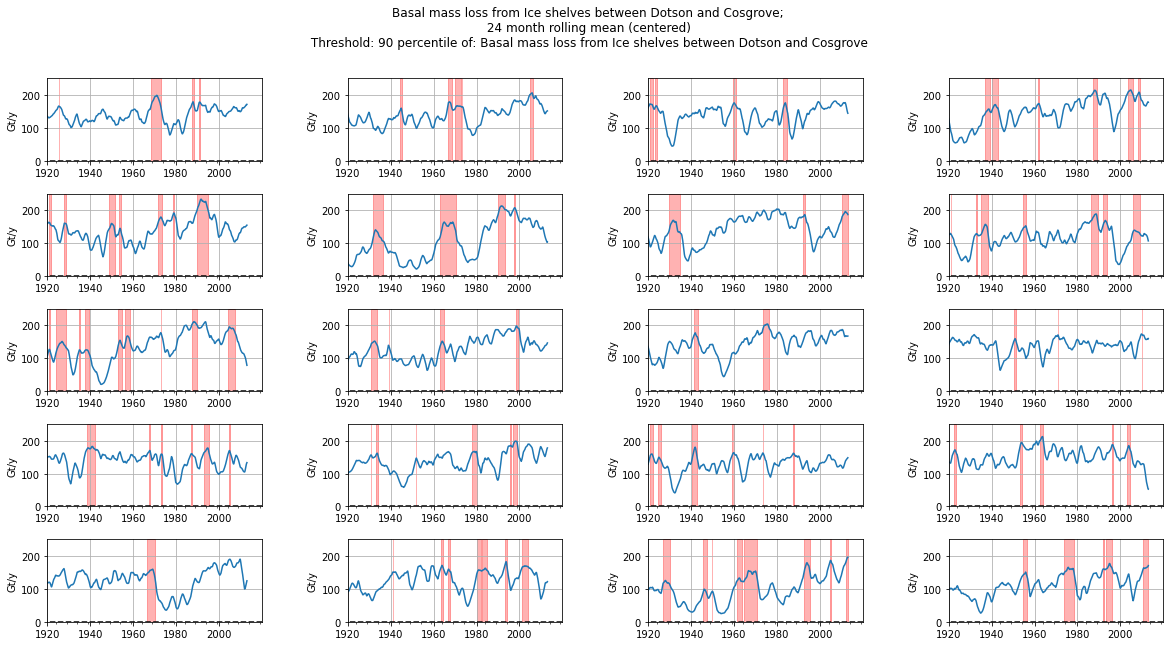

In [29]:
#STEP 1: FINDING MELT EVENTS

plt.figure(figsize=(20,10))

long=total[wvar]['1920':'2013'].rolling(12*25, min_periods=12*5, center=True).mean()

#threshold=np.nanpercentile(total[var].rolling(24, center=True).mean()['1920':'2013'], pct)
threshold=np.nanpercentile(total[wvar]['1920':'2013'].rolling(24, center=True).mean()-long, pct)
windows=[24]

selected=pd.DataFrame()

a=[pd.to_datetime(str(j)) for j in np.arange(1920, 2011, 20)]
b=[str(j) for j in np.arange(1920, 2011, 20)]
for i in range(len(total['dotson_to_cosgrove_massloss'].columns)):    
    ax=plt.subplot(5,4,i+1)
    #plot_lines(total, var='all_massloss', ax=ax, sel=select, time=['1930', '1950'])
    col=total[wvar].columns[i]
    #total[var][col].rolling(24, center=True).mean().plot()
    
    sel=(total[wvar][col]['1920':'2013'].rolling(24, center=True).mean()-total[wvar][col].rolling(25*12, min_periods=5*12, center=True).mean())>threshold
    
    selected[col]=sel
    
    show_selected_periods(sel, total, indnms=[wvar], windows=windows, xlim=[1920,2020], col=col, title='')

    plt.ylabel(units[wvar])    
    plt.ylim([0, 250])
    plt.xticks(a,b)
    ax.grid(True)
    

plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.suptitle(longnames[wvar]+';\n {} month rolling mean (centered)'.format(windows[0])+'\n Threshold: {} percentile of: '.format(pct)+longnames[wvar])


In [1]:
ref=None
pdir=[os.path.join(bd, f, 'output') for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)][0:1]
print('Refdata read from:')
print(pdir)

files=[os.path.join(pdir[0],f,'MITgcm/output.nc') for f in os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output') if (f[0]==str(1)) | (f[0]==str(2))]

for i, p in enumerate(pdir):
    print(p)
    fd=[os.path.join(p, f) for f in files]
    fd.sort()
    #t0 = time.time()
    b=xr.open_dataset(fd[0])
    b=b[[var]]
    if var=='THETA':
        b=b.sel(Z=slice(-200, -700)).mean(dim='Z')

    for f in fd[1:]:
        #print(f)
        a=xr.open_dataset(f)
        a=a[[var]]
        if var=='THETA':
            a=a.sel(Z=slice(-200, -700)).mean(dim='Z')
        b=xr.concat([b,a], dim='time')
        
    #t1 = time.time()
    #total = t1-t0
    #print('Time for reading dataset:' + str(total))
    
    if i==0:
        ref=b
    #else:
        #t0 = time.time()
    #    data=xr.concat([data,b], dim='ens')
        #t1 = time.time()
        #total = t1-t0
        #print('Time for reading concatenating:' + str(total))
    
ref=ref.mean(dim='time')



HOI


['200901',
 'calendar',
 '189001',
 '189101',
 '189201',
 '189301',
 '189401',
 '189501',
 '189601',
 '189701',
 '189801',
 '189901',
 '190001',
 '190101',
 '190201',
 '190301',
 '190401',
 '190501',
 '190601',
 '190701',
 '190801',
 '190901',
 '191001',
 '191101',
 '191201',
 '191301',
 '191401',
 '191501',
 '191601',
 '191701',
 '191801',
 '191901',
 '192001',
 '192101',
 '192201',
 '192301',
 '192401',
 '192501',
 '192601',
 '192701',
 '192801',
 '192901',
 '193001',
 '193101',
 '193201',
 '193301',
 '193401',
 '193501',
 '193601',
 '193701',
 '193801',
 '193901',
 '194001',
 '194101',
 '194201',
 '194301',
 '194401',
 '194501',
 '194601',
 '194701',
 '194801',
 '194901',
 '195001',
 '195101',
 '195201',
 '195301',
 '195401',
 '195501',
 '195601',
 '195701',
 '195801',
 '195901',
 '196001',
 '196101',
 '196201',
 '196301',
 '196401',
 '196501',
 '196601',
 '196701',
 '196801',
 '196901',
 '197001',
 '197101',
 '197201',
 '197301',
 '197401',
 '197501',
 '197601',
 '197701',
 '197801

In [ ]:
start_list=pd.DataFrame()
for ens in selected.columns:
    start=np.array([False,]*len(selected[ens]))
    for i in range(len(selected[ens])):
        if (selected[ens].iloc[i]==True) & (selected[ens].iloc[i-1]==False):
            start[i]=True
    start_list[ens]=pd.Series(start, index=selected[ens].index)
start_list

In [3]:
#Reading the Data

def month_diff(a, b):
    return round(((a - b)/np.timedelta64(1, 'M')))

pdir=[os.path.join(bd, f, 'output') for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)]
columns=start_list.columns
pdir.sort()
columns=columns.sort_values()
if members!='all':
    pdir=pdir[members[0]:members[-1]]
    columns=columns[members[0]:members[-1]]
#else:
    #pdir=[os.path.join(bd, f, 'output') for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)][members[0]:members[-1]]
    #columns=start_list.columns[members[0]:members[-1]]

    
data=None

for i, ens in enumerate(columns):
    years=start_list[ens][start_list[ens]==True].index.year.values
    print(i)
    print('Starting with '+ens)
    print(pdir[i])
    files=[os.path.join(pdir[i],f,'MITgcm/output.nc') for f in os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output') if any(year in f for year in years.astype(str))]
    filesmin1=[os.path.join(pdir[i],f,'MITgcm/output.nc') for f in os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output') if any(year in f for year in (years-1).astype(str))]
    filesmin2=[os.path.join(pdir[i],f,'MITgcm/output.nc') for f in os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output') if any(year in f for year in (years-2).astype(str))]
    files=filesmin2+filesmin1+files
    files.sort()
    
    b=xr.open_dataset(files[0])
    b=b[[var]]
    if var=='THETA':
        b=b.sel(Z=slice(-200, -700)).mean(dim='Z')

    for f in files[1:]:
        #print(f)
        a=xr.open_dataset(f)
        a=a[[var]]
        if var=='THETA':
            a=a.sel(Z=slice(-200, -700)).mean(dim='Z')
        b=xr.concat([b,a], dim='time')
    
    #NOTE: Hij neemt altijd de eerste maand mee van het volgende jaar.....

    times=b.indexes['time'].to_datetimeindex()

    reltime=np.ones(len(times))*99

    kappa=0
    for iota, t in enumerate(times[:-1]):
        if start_list[ens][start_list[ens]==True].index[kappa].year>=t.year:
            reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])
        else:
            kappa+=1
            reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])
    
    b['time']=reltime
    #reltime
    
    if i==0:
        data=b
    else:
        data=xr.concat([data,b], dim='time')    

        
#Only studying anomalies:
data=data-ref

Test


In [ ]:
#From my code to Kaitlin's code
from mitgcm_python_master.plot_latlon import latlon_plot
from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
from mitgcm_python_master.utils import real_dir, daily_to_monthly, fix_lon_range, split_longitude, mask_land_ice, moving_average, index_year_start, index_year_end, index_period, mask_2d_to_3d, days_per_month, add_time_dim, z_to_xyz, select_bottom, convert_ismr, mask_except_ice, xy_to_xyz, apply_mask, var_min_max, mask_3d, average_12_months, depth_of_isoline, mask_land, axis_edges
from mitgcm_python_master.plot_utils.latlon import shade_mask, overlay_vectors
from mitgcm_python_master.plot_utils.windows import finished_plot, set_panels

In [ ]:
vmax=data.quantile(0.8).to_array().to_numpy()[0]
vmin=data.quantile(0.2).to_array().to_numpy()[0]

for moi in np.arange(-25,1):
    #VISUALISATION:
    cors=data.sel(time=moi).mean(dim='time')
    #data
    #np.shape(cors.to_array().to_numpy()[0,:,:])
    cors=cors.to_array().to_numpy()[0,:,:]


    grid = Grid(gp)
    region=region
    mask = grid.get_region_mask(region)
    mask=mask.astype(bool)

    #Prepare everything for the map!
    r_data = np.zeros([grid.ny, grid.nx])
    #if show_p==True:
    #    r_data[mask] = cors[mask]
    #else:
    r_data[mask] = cors[mask]
    r_data = mask_land_ice(r_data, grid)
    #print(('Mean r over all points and ensemble members = '+str(np.nanmean(r_data))))
    r_data[np.isnan(r_data)]=0
      

    title_new=title+'\n ({} months before detected events)'.format(str(moi))



    #Plot the Map
    fig, ax=plt.subplots(figsize=(14,5))
    latlon_plot(r_data, grid, ctype='plusminus', vmin=None, vmax=None, title=title_new, titlesize=14, figsize=(14,5), ax=ax)
    #r=ax.contour(grid.lon_2d, grid.lat_2d, r_data, levels=levels, colors=['yellow'])
    #plt.clabel(r, levels)

    bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
    plt.clabel(bath, [-1000])

    #if show_p==True:
    #   p_data = np.zeros([grid.ny, grid.nx])
    #    p_data[mask] = p[mask]
    #    p_data = mask_land_ice(p_data, grid)
    #    a=5
    #    ax.scatter(grid.lon_2d[::a, ::a][(p_data[::a, ::a]<=0.05) & (p_data[::a, ::a].mask==False)], grid.lat_2d[::a, ::a][(p_data[::a, ::a]<=0.05) & (p_data[::a, ::a].mask==False)], c='k', s=.02)
    show_box=True
    if show_box==True:
        x=[-115, -102, -102, -115, -115]
        y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
        ax.plot(x, y, c='g', marker='o')
   

#finished_plot(fig, fig_name='./'+'correlation_map_'+tsvar+'_'+var+'_'+method+'_'+str(final_lag)+'.png', dpi=300)